In [1]:
import torch
import PyAPD

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [2]:
from torchmin import minimize
from torchmin.benchmarks import rosen

In [3]:
# initial point
x0 = torch.randn(100, device='cpu')

solver = 'newton-cg'
defaultKwargs = {#'gtol': gtol,
                 'xtol': 1e-6,
                 'disp': 1,
                 'max_iter':1000,
                 #'line_search': 'none',
                 #'lr': 1e-2,
                }

res = minimize(rosen, x0, method=solver,
         options=defaultKwargs,
        )

# BFGS
#result = minimize(rosen, x0, method='bfgs')

# Newton Conjugate Gradient
#result = minimize(rosen, x0, method='newton-cg')

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 192
         Function evaluations: 456
         CG iterations: 1542


In [4]:
res = PyAPD.minimize_torch(rosen, x0, method=solver,
         options=defaultKwargs,
        )

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 192
         Function evaluations: 456
         CG iterations: 1542


In [1]:
import PyAPD
from pykeops.torch import LazyTensor
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
dt = torch.float64
torch.set_default_dtype(dt)

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


Precision loss detected!
Percentage error =  18.36734962463379
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0050)
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -0.221925
         Iterations: 4
         Function evaluations: 25
It took 0.03807783126831055 seconds to find optimal W.


(<Figure size 756x756 with 1 Axes>, <Axes: >)

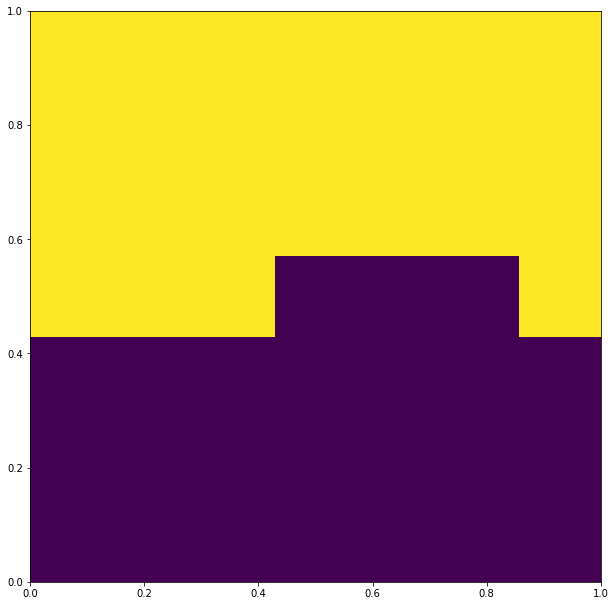

In [2]:
N = 2 # number of grains
apd1 = PyAPD.apd_system(
    N = N,
    seed = 5, # fix random seed
    pixel_size_prefactor = 0.5
)
apd1.check_optimality()
apd1.find_optimal_W()
apd1.plot_apd()

In [5]:
A = apd1.As
W = apd1.W
X = apd1.X
Y = apd1.Y
II = apd1.assemble_apd() # grain map

In [7]:
dims = A.shape

In [81]:
W_t = W.view(dims[0],1,1)
X_t = X.view(dims[0], 1, dims[1])
Y_t = Y.view(1, len(Y), 2)

MV_s = torch.einsum('bij,bkj->bki',A,Y_t-X_t)
D_ij_torch = torch.einsum('bkj,bkj->bk',MV_s,Y_t-X_t)

D_ij_torch = (D_ij_torch[:,:,None] - W_t)[:,:,0]

a = LazyTensor(A.view(dims[0], 1, dims[1] * dims[2]))
w = LazyTensor(W_t)
x = LazyTensor(X_t)
y = LazyTensor(Y_t)
D_ij = ((y - x) | a.matvecmult(y - x)) - w

In [82]:
comp1_keops = (y-x).sum(dim=0).sum(dim=1)

In [83]:
comp1_torch = (Y_t-X_t).sum(dim=0).sum(dim=1)

In [85]:
torch.max(torch.abs(comp1_keops-comp1_torch))

tensor(0.)

In [86]:
torch.abs(D_ij_torch.sum(dim=0) - D_ij.sum(dim=0)[:,0])

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1921e-07,
        1.1921e-07, 0.0000e+00, 0.0000e+00, 5.9605e-08, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 5.9605e-08, 0.0000e+00, 5.9605e-08, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.9802e-08, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.9605e-08, 5.9605e-08,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.9605e-08,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00])

In [48]:
apd1.W

tensor([ 0.0132, -0.0132])